In [1]:
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import precision_recall_curve

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report

from utils import load_train_test

In [2]:
train_filename = "application_train.csv"
test_filename = "application_test.csv"
path_to_data = "../data/"

### load train/test

In [3]:
df_application_train = load_train_test(
    filename=train_filename,
    path_to_train_folder=path_to_data,
)
df_application_test = load_train_test(
    filename=test_filename,
    path_to_train_folder=path_to_data,
)

### select features

In [4]:
# 23 features and y
features = [
    'TARGET',
    'NAME_CONTRACT_TYPE',
    'CODE_GENDER',
    'FLAG_OWN_CAR',
    'FLAG_OWN_REALTY',
    'CNT_CHILDREN',
    'AMT_INCOME_TOTAL',
    'AMT_CREDIT',
    'AMT_ANNUITY',
    'AMT_GOODS_PRICE',
    'NAME_TYPE_SUITE',
    'NAME_INCOME_TYPE',
    'NAME_FAMILY_STATUS',
    'DAYS_BIRTH',
    'DAYS_EMPLOYED',
    'DAYS_REGISTRATION',
    'DAYS_ID_PUBLISH',
    'FLAG_MOBIL',
    'FLAG_EMP_PHONE',
    'FLAG_WORK_PHONE',
    'FLAG_CONT_MOBILE',
    'FLAG_PHONE',
    'FLAG_EMAIL',
    'CNT_FAM_MEMBERS',
]

In [5]:
df_train = df_application_train[features]
df_test = df_application_test[features[1:]]

In [6]:
df_train.isna().sum()

TARGET                   0
NAME_CONTRACT_TYPE       0
CODE_GENDER              0
FLAG_OWN_CAR             0
FLAG_OWN_REALTY          0
CNT_CHILDREN             0
AMT_INCOME_TOTAL         0
AMT_CREDIT               0
AMT_ANNUITY             12
AMT_GOODS_PRICE        278
NAME_TYPE_SUITE       1292
NAME_INCOME_TYPE         0
NAME_FAMILY_STATUS       0
DAYS_BIRTH               0
DAYS_EMPLOYED            0
DAYS_REGISTRATION        0
DAYS_ID_PUBLISH          0
FLAG_MOBIL               0
FLAG_EMP_PHONE           0
FLAG_WORK_PHONE          0
FLAG_CONT_MOBILE         0
FLAG_PHONE               0
FLAG_EMAIL               0
CNT_FAM_MEMBERS          2
dtype: int64

In [7]:
df_test.isna().sum()

NAME_CONTRACT_TYPE      0
CODE_GENDER             0
FLAG_OWN_CAR            0
FLAG_OWN_REALTY         0
CNT_CHILDREN            0
AMT_INCOME_TOTAL        0
AMT_CREDIT              0
AMT_ANNUITY            24
AMT_GOODS_PRICE         0
NAME_TYPE_SUITE       911
NAME_INCOME_TYPE        0
NAME_FAMILY_STATUS      0
DAYS_BIRTH              0
DAYS_EMPLOYED           0
DAYS_REGISTRATION       0
DAYS_ID_PUBLISH         0
FLAG_MOBIL              0
FLAG_EMP_PHONE          0
FLAG_WORK_PHONE         0
FLAG_CONT_MOBILE        0
FLAG_PHONE              0
FLAG_EMAIL              0
CNT_FAM_MEMBERS         0
dtype: int64

In [8]:
df_train = df_train.dropna()

### processing

In [9]:
df_train = df_train[df_train['CODE_GENDER'].isin(['M', 'F'])]
df_test = df_test[df_test['CODE_GENDER'].isin(['M', 'F'])]

In [10]:
# label encoding
label_encoding_columns = [
    'NAME_CONTRACT_TYPE',
    'CODE_GENDER',
    'FLAG_OWN_CAR',
    'FLAG_OWN_REALTY',
    'NAME_TYPE_SUITE',
    'NAME_INCOME_TYPE',
    'NAME_FAMILY_STATUS',
]

label_encoding_dict = {}

for column in label_encoding_columns:
    label_encoding_dict[column] = LabelEncoder()
    df_train[column] = label_encoding_dict[column].fit_transform(df_train[column])

In [11]:
# make positive
for column in ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH']:
    df_train[column] = -1 * df_train[column]
    df_test[column] = -1 * df_test[column]

In [12]:
# drop DAYS_EMPLOYED == 350K
df_train = df_train[df_train['DAYS_EMPLOYED'] >= 0]

### modeling

In [13]:
X = df_train.drop(['TARGET'], axis=1)
y = df_train['TARGET']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42, stratify=y
)

In [15]:
clf = LogisticRegression(class_weight='balanced')
clf.fit(X=X_train, y=y_train)

LogisticRegression(class_weight='balanced')

In [16]:
print(
    classification_report(
        y_pred=clf.predict(X_test),
        y_true=y_test,
    )
)

              precision    recall  f1-score   support

           0       0.93      0.57      0.71     75654
           1       0.11      0.58      0.19      7185

    accuracy                           0.57     82839
   macro avg       0.52      0.58      0.45     82839
weighted avg       0.86      0.57      0.67     82839



### precision/recall

In [17]:
precision, recall, thresholds = precision_recall_curve(
    y_true=y_test,
    probas_pred=clf.predict_proba(X_test)[:, 0],
)

<ipython-input-18-e6802973f98f>:18: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(thresholds, 2*precision[:-1]*recall[:-1]/(precision[:-1]+recall[:-1]), label='f1')


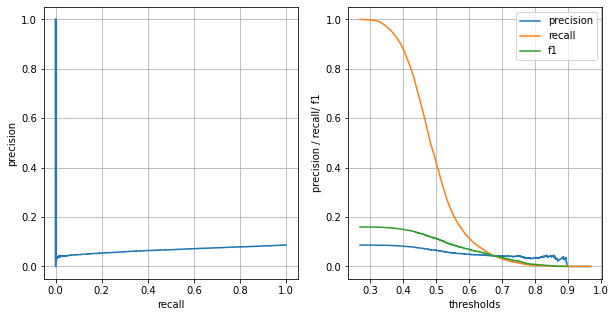

In [18]:
plt.figure(figsize=(10, 5))

###
plt.subplot(121)

plt.step(recall, precision)

plt.xlabel('recall')
plt.ylabel('precision')

plt.grid()

###
plt.subplot(122)

plt.plot(thresholds, precision[:-1], label='precision')
plt.plot(thresholds, recall[:-1], label='recall')
plt.plot(thresholds, 2*precision[:-1]*recall[:-1]/(precision[:-1]+recall[:-1]), label='f1')

plt.xlabel('thresholds')
plt.ylabel('precision / recall/ f1')

plt.legend()
plt.grid()

In [19]:
# correlation reduction: 7 features left
df_train = df_train.drop([
    'AMT_GOODS_PRICE',
    'CNT_FAM_MEMBERS',
    'AMT_ANNUITY',
],
    axis=1,
)

df_test = df_test.drop([
    'AMT_GOODS_PRICE',
    'CNT_FAM_MEMBERS',
    'AMT_ANNUITY',
],
    axis=1,
)

### fir model

In [20]:
X_train_sample, y_train_sample = RandomUnderSampler().fit_resample(
    X=X_train,
    y=y_train,
)

In [21]:
X_train_sample_normed = StandardScaler().fit_transform(X_train_sample)

In [22]:
clf = LogisticRegression()

In [23]:
cv = StratifiedKFold(n_splits=5)

In [24]:
for score in ['accuracy', 'precision', 'recall', 'f1']:
    result = cross_val_score(
        estimator=clf,
        X=X_train_sample_normed,
        y=y_train_sample,
        scoring=score,
        cv=cv,
    )
    
    print(f"{score}: {round(result.mean(), 3)}")

accuracy: 0.611
precision: 0.604
recall: 0.647
f1: 0.625
